En este archivo voy a comenzar a realizar la fase de experimentación de mi trabajo de fin de grado. La idea general es estudiar la aplicabilidad de modelos fundacionales, en nuestra caso scGPT, a tareas dedicadas a través del Transfer Learning. 

Estos modelos se pueden poner a prueba bien a través de Hugginface o bien a través de librerías de Python. Además, necesitaremos realizar un estudio sobre el/los datasets que emplearemos con estos modelos. Por ello, de forma preliminar, necesitaremos estudiar:

-Puesta en marcha de modelos en dispositivos locales(HugginFace, Github, Librerías...) con los datasets de prueba.
-Datasets a emplear.
-Tratamiento de los Datasets con todas las fases típicas de un proyecto de Data Science.
-Tratamiento de los datasets de forma específica para que los datos sean compatibles con los modelos.

Tras unos primeros problemas para la implementación del modelo usando HugginFace, paso a instalarlo siguiendo las directrices del repositorio GitHub.

Comenzaremos por estudiar los datasets que trabajaron el equipo de scGPT, formatos .h5ad, objetos AnnData, librerías scanpy...

In [1]:
import scanpy as sc

adata_pancreas = sc.read_h5ad("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Datasets/single-cell/human_pancreas_norm_complexBatch.h5ad")


In [ ]:
# Celda para leer datasets en formato .h5ad, devuelve objetos AnnData
# Para visualizar recomiendo usar el formato DataFrame
import scanpy as sc
import pandas as pd
from scipy.sparse import csr_matrix


#En var sólo se almacenan, en este caso, los nombres de los genes
adata_pancreas.var_names

# Convertimos a matriz dispersa para visualizar mejor
#adata_pancreas.X
adata_pancreas.X = csr_matrix(adata_pancreas.X)

adata_df = pd.DataFrame(adata_pancreas.X.toarray(), index=adata_pancreas.obs_names, columns=adata_pancreas.var_names)
#adata_df.head()


# Valores de expresión entre células y genes
# Los valores pueden ir desde 0 hasta valores como 5575.82
#adata_pancreas.layers["counts"].max(axis=0)

array([ 468.  , 1637.  , 5575.82, ..., 2436.  , 1723.72,  515.  ],
      dtype=float32)

In [31]:
#Podemos sacar los índices a una columna en sí
gene_col = "Gene Symbol"
adata_pancreas.var[gene_col] = adata_pancreas.var.index.values
adata_pancreas.var



,Gene Symbol
A1BG,A1BG
A1CF,A1CF
A2M,A2M
A2ML1,A2ML1
A4GALT,A4GALT
...,...
ZXDC,ZXDC
ZYG11B,ZYG11B
ZYX,ZYX
ZZEF1,ZZEF1


In [32]:
adata_pancreas_copy = adata_pancreas.copy()

In [33]:
#Selection of highly variable genes
N_HVG = 1800 #¿Por qué son 1800?

# Pre-procesamiento
sc.pp.normalize_total(adata_pancreas, target_sum=1e4)
sc.pp.log1p(adata_pancreas)

#highly variable genes
sc.pp.highly_variable_genes(adata_pancreas, n_top_genes=N_HVG, flavor="seurat_v3")
# Cuando hacemos subsetting, tenemos primero obs y después var
adata_pancreas = adata_pancreas[:, adata_pancreas.var['highly_variable']]


/Users/doblado/miniforge3/envs/envTFG/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
# Observamos todos los cambios generados en los datos
print(adata_pancreas)

# ¿Todos son áltamente variables?
#boolean_s = adata_pancreas[:,adata_pancreas.var["highly_variable"] == False] # Es un booleano
#print(boolean_s.var)

adata_pancreas.obs
adata_df2 = pd.DataFrame(adata_pancreas.X.toarray(), index=adata_pancreas.obs_names, columns=adata_pancreas.var_names)

print("----- Highly Variable -----")
#print(adata_df2.head(10))
adata_df2.sort_index(axis=1,level=0)
# Si comparamos con la celda de abajo, vemos que los genes no son los mismos
# tras las transformaciones
#adata_df2["A1BG"]

View of AnnData object with n_obs × n_vars = 16382 × 1800
    obs: 'tech', 'celltype', 'size_factors'
    var: 'Gene Symbol', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'
----- Highly Variable -----


View of AnnData object with n_obs × n_vars = 16382 × 1800
    obs: 'tech', 'celltype', 'size_factors'
    var: 'Gene Symbol', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [45]:
# Quiero comparar ámbos, quería ver que efectivamente muestran distintos genes
# Tras comprobarlos, voy a ordenarlos para visualizar lo mismo
print("----- Raw Data -----")
#print(adata_df.head(5))
adata_df.sort_index(axis=1,level=0)
adata_df["A1BG"]

----- Raw Data -----


D101_5         0.000000
D101_43        2.612081
D101_93        0.000000
D102_4         3.091586
D172444_23     0.000000
                 ...   
Sample_1594    0.000000
Sample_1595    2.213732
Sample_1597    0.429963
Sample_1598    3.469557
Sample_1600    0.456665
Name: A1BG, Length: 16382, dtype: float32

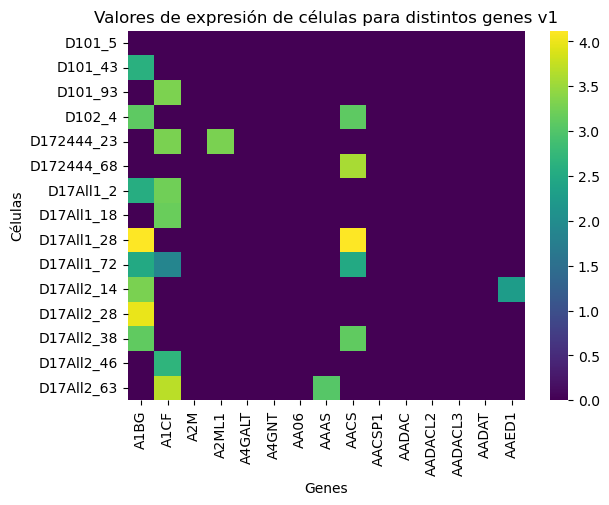

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(adata_df.iloc[:15, :15], cmap="viridis")
plt.title("Valores de expresión de células para distintos genes v1")
plt.ylabel("Células")
plt.xlabel("Genes")
plt.show()

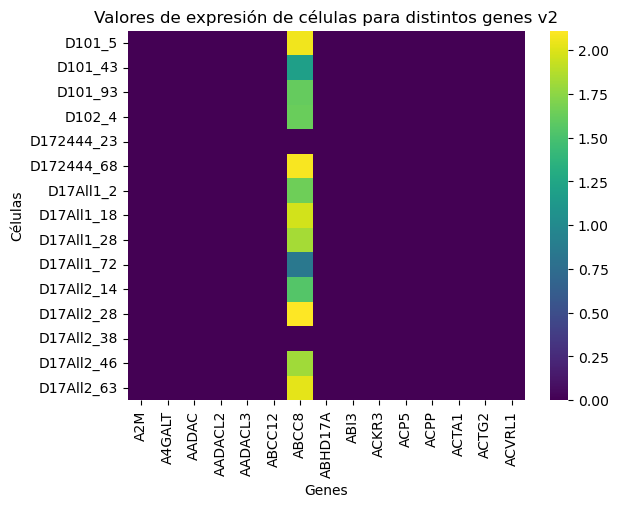

In [48]:
#Podemos observar como sí ha cambiado bastante la representación
sns.heatmap(adata_df2.iloc[:15, :15], cmap="viridis")
plt.title("Valores de expresión de células para distintos genes v2")
plt.ylabel("Células")
plt.xlabel("Genes")
plt.show()

Pasamos a analizar el dataset de esclerosis múltiple, usado en scGPT para la tarea de cell type annotation

In [3]:
import scanpy as sc

adata_sclerosis = sc.read_h5ad("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Experimentación/data/ms/esclerosis_scGPT_data.h5ad")

In [1]:
import scanpy as sc

adata_sclerosis_filtrado = sc.read_h5ad("/Users/doblado/Transformers-Architecture-in-Bioinformatics/Experimentación/data/ms/filtered_ms_adata.h5ad")

In [13]:
# Parece que ya han sido "sometidos" al proceso de HGV
adata_sclerosis
adata_sclerosis.obs["Factor Value[inferred cell type - authors labels]"]
adata_sclerosis.var

,index_column,gene_name,highly_variable,highly_variable_rank,means,variances,variances_norm
gene_name,,,,,,,
CFH,ENSG00000000971,CFH,True,1146.0,0.554705,1.299630,1.287233
BAD,ENSG00000002330,BAD,True,1847.0,0.111168,0.155943,1.191933
LAP3,ENSG00000002549,LAP3,True,2582.0,0.024860,0.028835,1.142070
CD99,ENSG00000002586,CD99,True,1831.0,0.006247,0.007229,1.192886
WNT16,ENSG00000002745,WNT16,True,1631.0,0.006884,0.008113,1.212248
...,...,...,...,...,...,...,...
IGHG1,ENSG00000277633,IGHG1,True,820.0,0.000829,0.001051,1.368511
GSTT1,ENSG00000277656,GSTT1,True,996.0,0.072794,0.108050,1.321665
TRAC,ENSG00000277734,TRAC,True,2012.0,0.002167,0.002418,1.178153


In [12]:
print(adata_sclerosis_filtrado)
adata_sclerosis_filtrado.obs

AnnData object with n_obs × n_vars = 13468 × 3000
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[developmental stage]', 'Sample Characteristic Ontology Term[developmental stage]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[sampling site]', 'Sample Characteristic Ontology Term[sampling site]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[cause of death]', 'Sample Characteristic Ontology Term[cause of death]', 'Sample Characteristic[clinical history]', 'Sample 

,Sample Characteristic[organism],Sample Characteristic Ontology Term[organism],Sample Characteristic[individual],Sample Characteristic Ontology Term[individual],Sample Characteristic[sex],Sample Characteristic Ontology Term[sex],Sample Characteristic[age],Sample Characteristic Ontology Term[age],Sample Characteristic[developmental stage],Sample Characteristic Ontology Term[developmental stage],...,Factor Value[disease],Factor Value Ontology Term[disease],Factor Value[sampling site],Factor Value Ontology Term[sampling site],Factor Value[inferred cell type - ontology labels],Factor Value Ontology Term[inferred cell type - ontology labels],Factor Value[inferred cell type - authors labels],Factor Value Ontology Term[inferred cell type - authors labels],str_batch,celltype
SRR9123033-AAACCTGAGCTAGCCC,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS1,NaN,female,http://purl.obolibrary.org/obo/PATO_0000383,35 year,NaN,human adult stage,http://purl.obolibrary.org/obo/HsapDv_0000087,...,multiple sclerosis,http://purl.obolibrary.org/obo/MONDO_0005301,premotor cortex,http://purl.obolibrary.org/obo/UBERON_0016634,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,oligodendrocyte A,http://purl.obolibrary.org/obo/CL_0000128,1,oligodendrocyte A
SRR9123033-AAACCTGCAGACGCCT,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS1,NaN,female,http://purl.obolibrary.org/obo/PATO_0000383,35 year,NaN,human adult stage,http://purl.obolibrary.org/obo/HsapDv_0000087,...,multiple sclerosis,http://purl.obolibrary.org/obo/MONDO_0005301,premotor cortex,http://purl.obolibrary.org/obo/UBERON_0016634,cortical interneuron,http://purl.obolibrary.org/obo/CL_0008031,PVALB-expressing interneuron,http://purl.obolibrary.org/obo/CL_4023018,1,PVALB-expressing interneuron
SRR9123033-AAAGATGGTAGCGTAG,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS1,NaN,female,http://purl.obolibrary.org/obo/PATO_0000383,35 year,NaN,human adult stage,http://purl.obolibrary.org/obo/HsapDv_0000087,...,multiple sclerosis,http://purl.obolibrary.org/obo/MONDO_0005301,premotor cortex,http://purl.obolibrary.org/obo/UBERON_0016634,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,oligodendrocyte A,http://purl.obolibrary.org/obo/CL_0000128,1,oligodendrocyte A
SRR9123033-AAAGATGGTGCCTGGT,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS1,NaN,female,http://purl.obolibrary.org/obo/PATO_0000383,35 year,NaN,human adult stage,http://purl.obolibrary.org/obo/HsapDv_0000087,...,multiple sclerosis,http://purl.obolibrary.org/obo/MONDO_0005301,premotor cortex,http://purl.obolibrary.org/obo/UBERON_0016634,oligodendrocyte precursor cell,http://purl.obolibrary.org/obo/CL_0002453,oligodendrocyte precursor cell,http://purl.obolibrary.org/obo/CL_0002453,1,oligodendrocyte precursor cell
SRR9123033-AAAGTAGCACCAGGTC,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS1,NaN,female,http://purl.obolibrary.org/obo/PATO_0000383,35 year,NaN,human adult stage,http://purl.obolibrary.org/obo/HsapDv_0000087,...,multiple sclerosis,http://purl.obolibrary.org/obo/MONDO_0005301,premotor cortex,http://purl.obolibrary.org/obo/UBERON_0016634,oligodendrocyte,http://purl.obolibrary.org/obo/CL_0000128,oligodendrocyte A,http://purl.obolibrary.org/obo/CL_0000128,1,oligodendrocyte A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR9123052-TTTGGTTCATCCGGGT,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS9,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,55 year,NaN,human adult stage,http://purl.obolibrary.org/obo/HsapDv_0000087,...,multiple sclerosis,http://purl.obolibrary.org/obo/MONDO_0005301,cerebral cortex,http://purl.obolibrary.org/obo/UBERON_0000956,cortical layer 5-6 excitatory neuron,NaN,cortical layer 5-6 excitatory neuron,NaN,1,cortical layer 5-6 excitatory neuron
SRR9123052-TTTGGTTCATCGATGT,Homo sapiens,http://purl.obolibrary.org/obo/NCBITaxon_9606,MS9,NaN,male,http://purl.obolibrary.org/obo/PATO_0000384,5